# Importing Libraries

In [ ]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import re
import seaborn as sns

# libraries for pre-processing
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import cufflinks
from nltk import word_tokenize
import plotly.graph_objs as go
from plotly.offline import iplot
from nltk.stem import WordNetLemmatizer,PorterStemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler

# libraries for modelling
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# libraries for neural networks
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, Bidirectional
from keras.layers import GlobalMaxPool1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers import Input

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Processing Data

In [ ]:
# importing data
df = pd.read_csv("/content/drive/MyDrive/cyberbullying_tweets.csv")
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
# displaying the number of tweets per class
df["cyberbullying_type"].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

In [ ]:
# here a function preprocess is defined this function does all the necessary 
# preprocessing to make it suitable for further analysis and modelling.

def preprocess(df):
  stop_words = set(stopwords.words('english'))
  def preprocess_text(tweet):
    # Remove links and mentions
    processed_tweet = re.sub(r"(?:\@|https?\://)\S+", "", tweet)
    # Remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    processed_tweet = re.sub(r'[^\x00-\x7f]',r'', processed_tweet)
    # Remove punctuations and numbers
    processed_tweet = re.sub('[^a-zA-Z]', ' ', processed_tweet)
    # Single character removal
    processed_tweet = re.sub(r"\s+[a-zA-Z]\s+", ' ', processed_tweet)
    # Removing multiple spaces
    processed_tweet = re.sub(r'\s+', ' ', processed_tweet)
    # Tokenize the sentences and remove the stop words
    tokens = []
    for word in processed_tweet.split():
        if word.lower() not in stop_words:
            tokens.append(word)
    # Join the remaining words back
    processed_tweet = ' '.join(tokens)

    return processed_tweet

  x = []
  # adding processed tweets column to the data. 
  tweets = list(df["tweet_text"])
  for tweet in tweets:
      x.append(preprocess_text(tweet))
  df['processed_tweet'] = x

  # removing duplicates from the data.
  df.drop_duplicates('processed_tweet', inplace=True)

  # label_encoder = LabelEncoder()
  # df["cyberbullying_type"] = label_encoder.fit_transform(df["cyberbullying_type"])
  # # print(df["cyberbullying_type"])

  # dropping all the rows related to class "other_cyberbullying"
  df = df[df["cyberbullying_type"]!="other_cyberbullying"]

  # creating a second dataframe as the original one.
  # this will used for creating neural network.
  test_df = df.copy()

  # the different classes are assigned numbers. 
  ENCODE_DICT = {'not_cyberbullying': 0,
             'gender': 1,
             'religion': 2,
             'age': 3,
             'ethnicity': 4}
  df['cyberbullying_type'] = df.cyberbullying_type.replace(ENCODE_DICT)

  # the data is split into training and testing sets 
  # with 80% training data and 20% testing data.
  X_train, X_test, y_train, y_test = train_test_split(df["processed_tweet"], df["cyberbullying_type"], test_size=0.2, random_state=42, shuffle=True)

  # the second dataframe and the training and testing data are returned.
  return test_df, X_train, X_test, y_train, y_test

In [ ]:
# the data is preprocessed by calling preprocessing function.
test_df, X_train, X_test, y_train, y_test = preprocess(df)

In [ ]:
# this is how the data looks after preprocessing.
test_df

,tweet_text,cyberbullying_type,processed_tweet
0,"In other words #katandandre, your food was cra...",not_cyberbullying,words katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white MKR theblock ImACelebrityAU tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcakes
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks heads concerned another angry dude ...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,ISIS account pretending Kurdish account Like I...
...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,Black ppl expected anything depended anything ...
47688,Turner did not withhold his disappointment. Tu...,ethnicity,Turner withhold disappointment Turner called c...
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,swear God dumb nigger bitch got bleach hair re...
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,Yea fuck RT YOURE NIGGER FUCKING UNFOLLOW FUCK...


In [ ]:
test_df["cyberbullying_type"].value_counts()

religion             7961
age                  7911
ethnicity            7798
not_cyberbullying    7679
gender               7638
Name: cyberbullying_type, dtype: int64

In [ ]:
df = df.drop('tweet_text', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



# EDA

Text(0.5, 1.0, 'Tweets distribution by cyberbullying types')

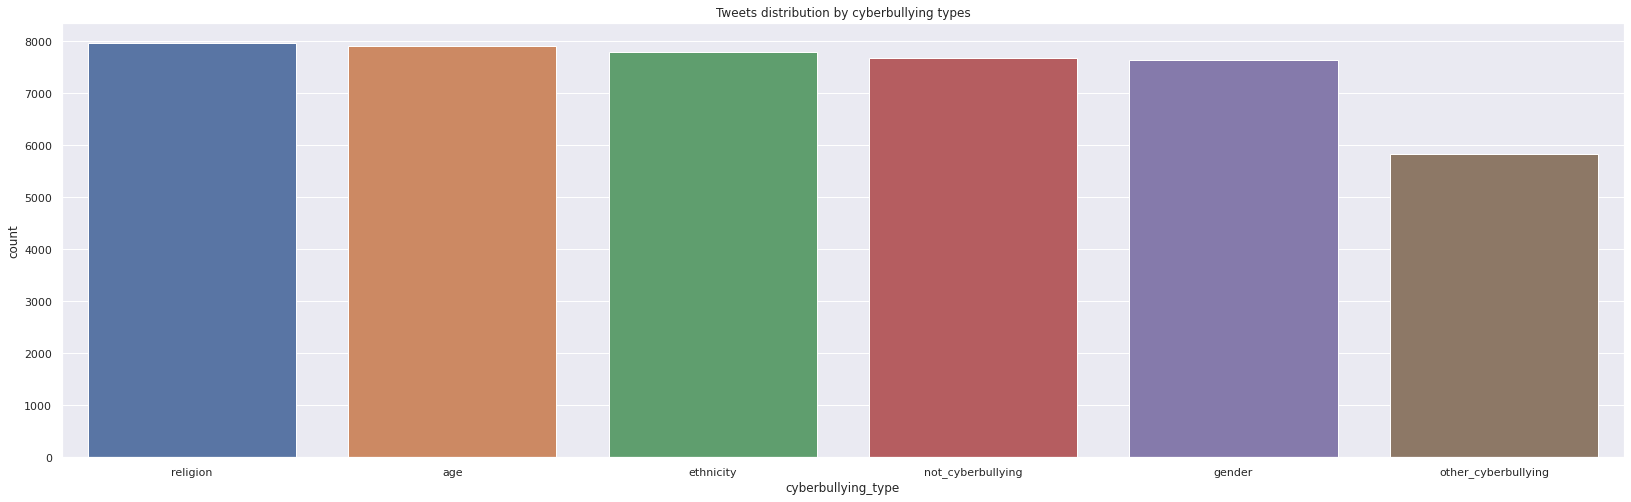

In [ ]:
# here all number of tweets per class are visualized.
# it can be seeen that each class has around 8000 tweets associated with it.

sns.set(rc={'figure.figsize':(28,8)})
sns.countplot(x="cyberbullying_type", data=df, order=df.cyberbullying_type.value_counts().index).set_title("Tweets distribution by cyberbullying types")

In [ ]:
# the average, min and max tweet length is calculated here.

df["tweet_length"] = df.processed_tweet.map(lambda x: len(x))
tweet_length_stats = df[["cyberbullying_type", "tweet_length"]].groupby("cyberbullying_type").mean()
tweet_length_stats["min"] = df[["cyberbullying_type", "tweet_length"]].groupby("cyberbullying_type").min().tweet_length
tweet_length_stats["max"] = df[["cyberbullying_type", "tweet_length"]].groupby("cyberbullying_type").max().tweet_length
tweet_length_stats

,tweet_length,min,max
cyberbullying_type,,,
age,109.194666,5,953
ethnicity,88.269043,4,1114
gender,83.155931,2,777
not_cyberbullying,46.948821,0,947
other_cyberbullying,46.636286,2,2510
religion,123.988569,4,285


In [ ]:
# a plot with tweet length vs count is shown here.
px.histogram(df[df["tweet_length"] < 1000], x="tweet_length", color="cyberbullying_type", title="Twitters Length Distribution Plot")

In [ ]:
# Plotting the top 15 words of each cyberbullying type
for cyber_type in df.cyberbullying_type.unique():
    
    top50_word = df.processed_tweet[df.cyberbullying_type==cyber_type].str.split(expand=True).stack().value_counts()[:15]
    
    fig = px.bar(top50_word, color=top50_word.values, color_continuous_scale=px.colors.sequential.RdPu, custom_data=[top50_word.values])
    fig.update_traces(marker_color='red')
    fig.update_traces(hovertemplate='<b>Count: </b>%{customdata[0]}')
    fig.update_layout(title=f"Top 15 words for {cyber_type}",
                     template='simple_white',
                     hovermode='x unified')
    fig.show()

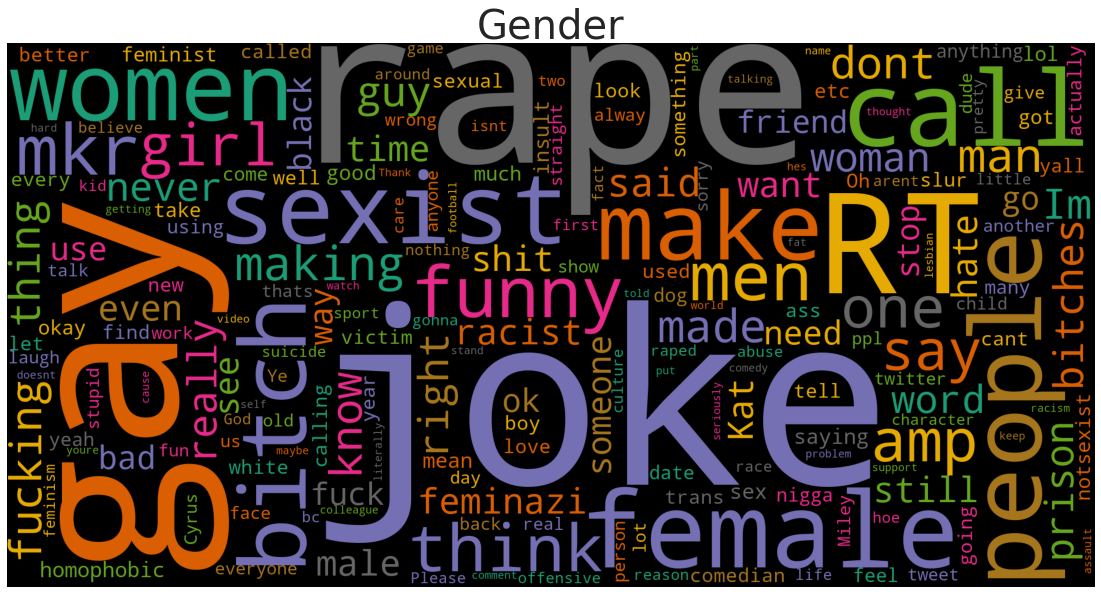

In [ ]:
# wordcloud of gender class is plotted.

plt.figure(figsize=(20,10))
subset1 = df[df['cyberbullying_type']=='gender']
text_gender = subset1.processed_tweet.values
cloud1=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_gender))

plt.axis('off')
plt.title("Gender",fontsize=40)
plt.imshow(cloud1)

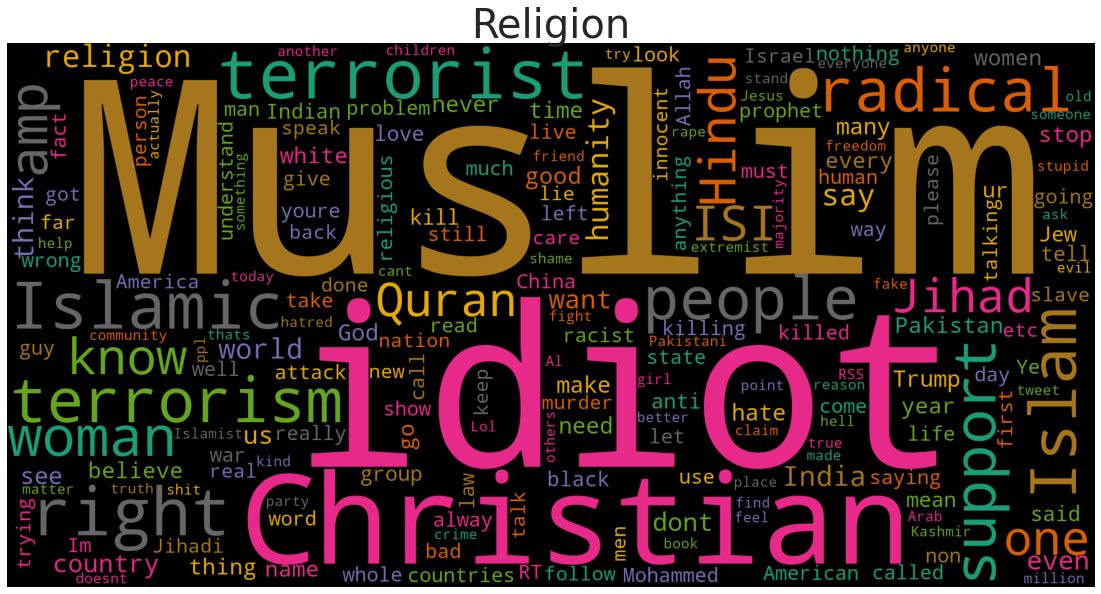

In [ ]:
# wordcloud of religion class is plotted.

plt.figure(figsize=(20,10))
subset2 = df[df['cyberbullying_type']=='religion']
text_religion = subset2.processed_tweet.values
cloud2=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_religion))

plt.axis('off')
plt.title("Religion",fontsize=40)
plt.imshow(cloud2)

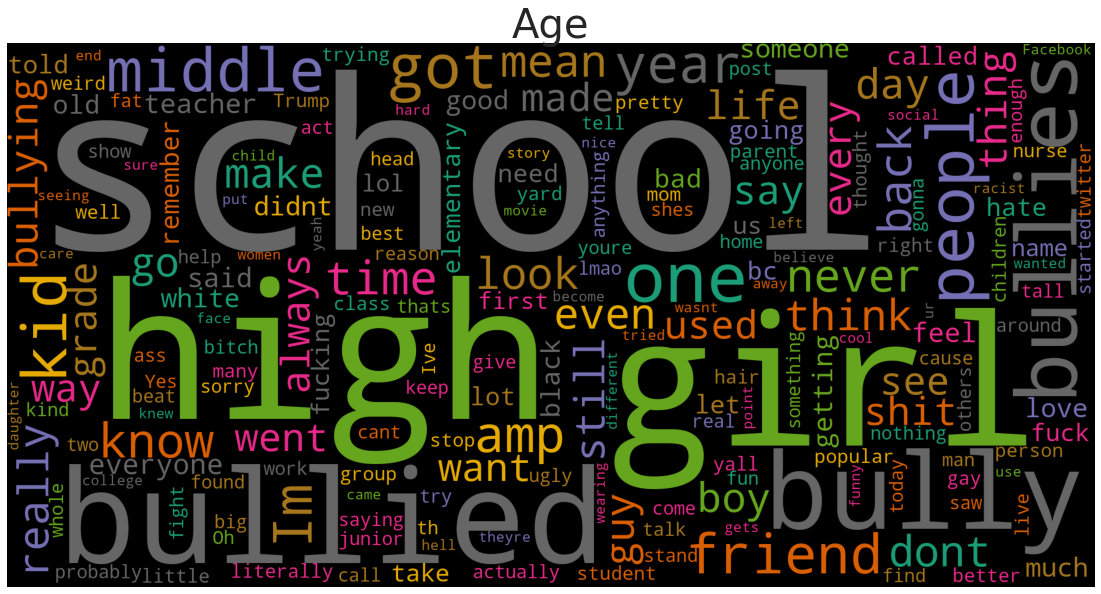

In [ ]:
# wordcloud of age class is plotted.

plt.figure(figsize=(20,10))
subset3 = df[df['cyberbullying_type']=='age']
text_age = subset3.processed_tweet.values
cloud3=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_age))

plt.axis('off')
plt.title("Age",fontsize=40)
plt.imshow(cloud3)

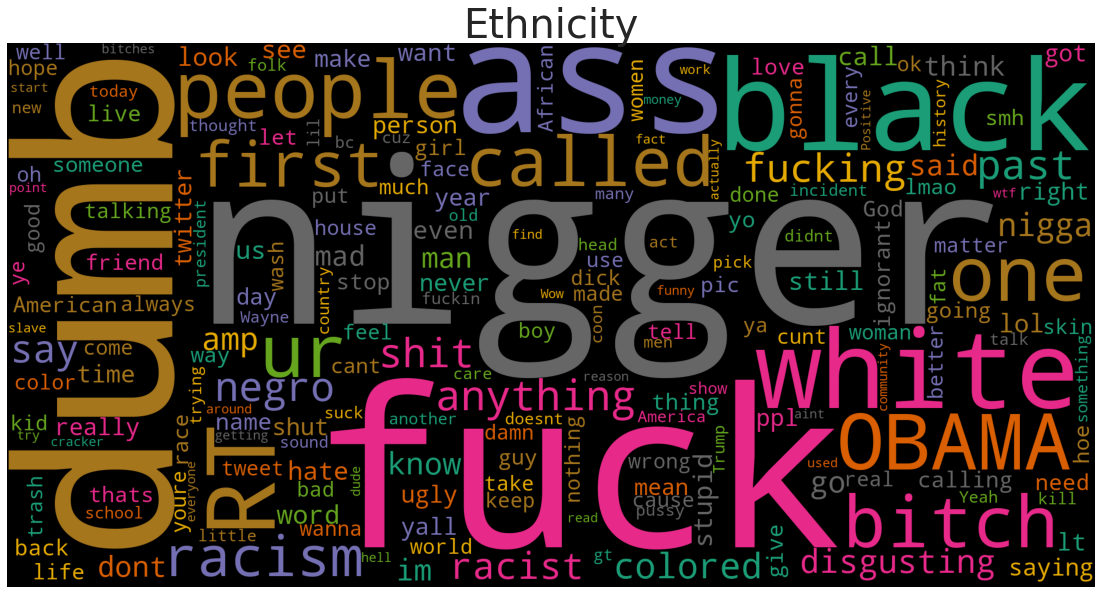

In [ ]:
# wordcloud of ethnicity class is plotted.

plt.figure(figsize=(20,10))
subset4 = df[df['cyberbullying_type']=='ethnicity']
text_ethnicity = subset4.processed_tweet.values
cloud4=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_ethnicity))

plt.axis('off')
plt.title("Ethnicity",fontsize=40)
plt.imshow(cloud4)

# Modelling






In [ ]:
# training and testing data shapes are displayed here.
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((31189,), (7798,), (31189,), (7798,))

## tfidf Tokenization

In [ ]:
tfidf = TfidfVectorizer(max_features = 5000)

X_train_tfidf = tfidf.fit_transform(X_train)  # Creating the vocabulary only from the training set to avoid data leakage from 
X_test_tfidf = tfidf.transform(X_test)  

# scaler = StandardScaler()
tfidf_array_train = X_train_tfidf.toarray()   # Converting the sparse matrix to a numpy array (dense matrix)
tfidf_array_test = X_test_tfidf.toarray()     # Converting the sparse matrix to a numpy array (dense matrix)
# scaled_X_train = scaler.fit_transform(tfidf_array_train)  # Fitting on only training data to avoid data leakage from test data
# scaled_X_test = scaler.transform(tfidf_array_test) # and then tranforming both training and testing data

## Models

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1567
           1       0.95      0.86      0.90      1548
           2       0.97      0.96      0.96      1540
           3       0.96      0.97      0.96      1549
           4       0.98      0.98      0.98      1594

    accuracy                           0.93      7798
   macro avg       0.93      0.93      0.93      7798
weighted avg       0.93      0.93      0.93      7798



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



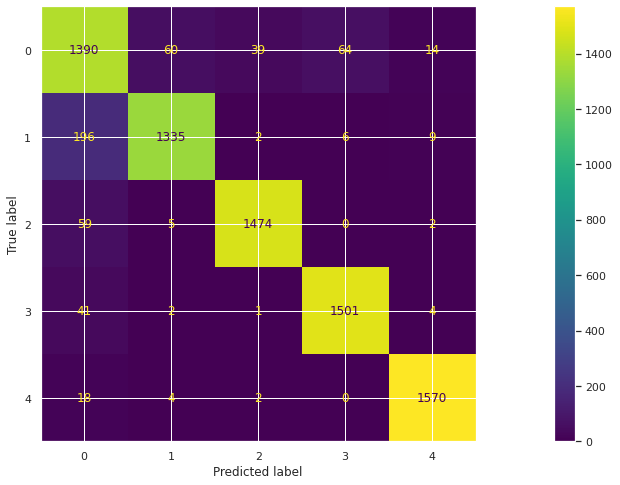

In [ ]:
# LOGISTIC REGRESSION

# logistic regression model is initialized
log_model = LogisticRegression(solver = 'saga')
# a parameter grid is defined.
# this will be grid based on which the model will be obtimized
param_grid = {'C': np.logspace(0, 10, 5)}
# we start the grid search.
# and the fit the data to the model.
grid_log_model = HalvingGridSearchCV(log_model, param_grid = param_grid, n_jobs = -1, min_resources = 'exhaust', factor = 3)
grid_log_model.fit(X_train_tfidf, y_train)
# the predictions are made by the optimized model.
preds_grid_log_model = grid_log_model.predict(X_test_tfidf)
# the classification report is generated to see the model performance.
print(classification_report(y_test, preds_grid_log_model))
# the confusion matrix is plotted to see how much of the data is 
# correctly classsified.
plot_confusion_matrix(grid_log_model, X_test_tfidf, y_test)

In [ ]:
# this code block tries to fit the data on multiple models.
# the accuracy of these different models is checked.

# the various models are initialized.
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
lgb = LGBMClassifier(random_state=42)
xgb = XGBClassifier(eval_metric="mlogloss",random_state=42)
#mlp = MLPClassifier(random_state=42)
nb = MultinomialNB()
svc = SVC()

clfs = {
    "Random Forest": rf,
    "Gradient Boosting":gb,
    "LightGBM": lgb,
    "XGBoost": xgb,
    "Naive Bayes": nb,
    "Support Vector Machines": svc
}

# this function fits the data on each of the models defined above.
# the testing accuracy is returned.
def fit_model(clf,x_train,y_train,x_test, y_test):
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_pred, y_test)
    return accuracy

# this variable store the accuracies of each the models.
accuracys = []

# the above function is called by passing the data.
for name,clf in clfs.items():
    curr_acc = fit_model(clf,X_train_tfidf,y_train,X_test_tfidf,y_test)
    accuracys.append(curr_acc)

# a temperary dataframe is created to store the accuracies.
models_df = pd.DataFrame({"Models":clfs.keys(),"Accuracy Scores":accuracys}).sort_values('Accuracy Scores',ascending=False)
models_df

,Models,Accuracy Scores
0,Random Forest,0.940626
2,LightGBM,0.940498
1,Gradient Boosting,0.935753
5,Support Vector Machines,0.934599
3,XGBoost,0.928315
4,Naive Bayes,0.855604


              precision    recall  f1-score   support

           0       0.76      0.96      0.85      1567
           1       0.98      0.79      0.88      1548
           2       0.98      0.94      0.96      1540
           3       0.99      0.97      0.98      1549
           4       1.00      0.98      0.99      1594

    accuracy                           0.93      7798
   macro avg       0.94      0.93      0.93      7798
weighted avg       0.94      0.93      0.93      7798



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



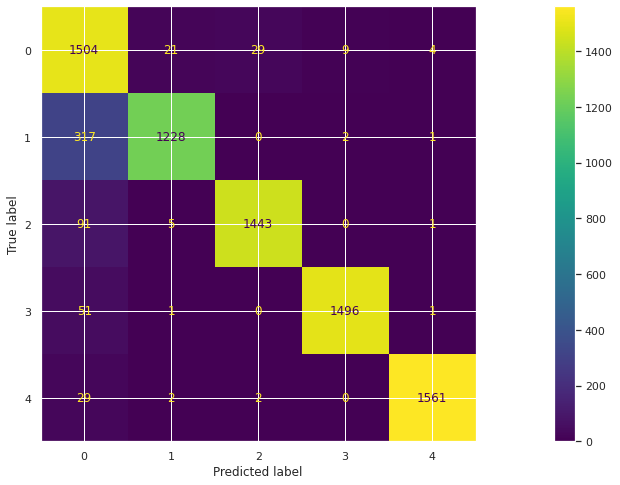

In [ ]:
# the lightgbm model is initialized.
lgm_model = LGBMClassifier(random_state=42)
# a parameter grid is defined.
# this will be grid based on which the model will be obtimized
param_grid = {'learning_rate_init': [0.001, 0.0015, 0.002, 0.0025], 'max_depth': [-3, -2, -1, 0, 1, 2, 3]}
# we start the grid search.
# and the fit the data to the model.
grid_lgm_model = HalvingGridSearchCV(lgm_model, param_grid = param_grid, n_jobs = -1, min_resources = 'exhaust', factor = 3)
grid_lgm_model.fit(X_train_tfidf, y_train)
# the predictions are made by the optimized model.
preds_grid_lgm_model = grid_lgm_model.predict(X_test_tfidf)
# the classification report is generated to see the model performance.
print(classification_report(y_test, preds_grid_lgm_model))
# the confusion matrix is plotted to see how much of the data is 
# correctly classsified.
plot_confusion_matrix(grid_lgm_model, X_test_tfidf, y_test)

In [ ]:
# best parameters
grid_lgm_model.best_params_ 

{'learning_rate_init': 0.002, 'max_depth': 3}

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1567
           1       0.95      0.85      0.90      1548
           2       0.97      0.97      0.97      1540
           3       0.98      0.97      0.98      1549
           4       0.99      0.99      0.99      1594

    accuracy                           0.94      7798
   macro avg       0.94      0.94      0.94      7798
weighted avg       0.94      0.94      0.94      7798



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



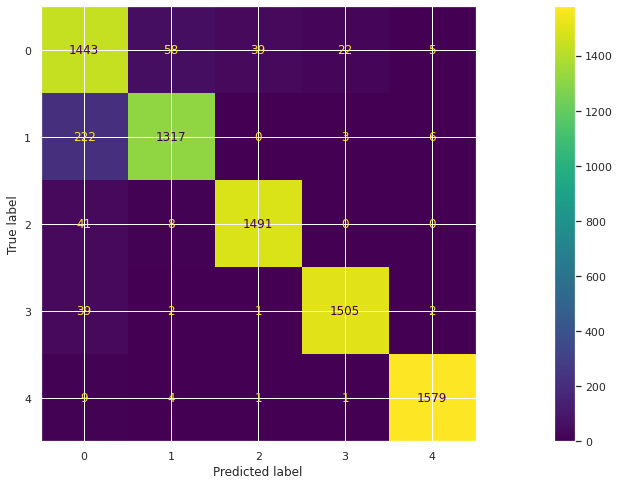

In [ ]:
# the random forest model is initialized.
rf_model = RandomForestClassifier(random_state=42)
# a parameter grid is defined.
# this will be grid based on which the model will be obtimized
param_grid = {'criterion':["gini", "entropy"]}
# we start the grid search.
# and the fit the data to the model.
grid_rf_model = HalvingGridSearchCV(rf_model, param_grid = param_grid, n_jobs = -1, min_resources = 'exhaust', factor = 3)
grid_rf_model.fit(X_train_tfidf, y_train)
# the predictions are made by the optimized model.
preds_grid_rf_model = grid_rf_model.predict(X_test_tfidf)
# the classification report is generated to see the model performance.
print(classification_report(y_test, preds_grid_rf_model))
# the confusion matrix is plotted to see how much of the data is 
# correctly classsified.
plot_confusion_matrix(grid_rf_model, X_test_tfidf, y_test)

In [ ]:
# best parameters
grid_rf_model.best_params_ 

{'criterion': 'gini'}

## Neural Networks

In [ ]:
test_df

,tweet_text,cyberbullying_type,processed_tweet
0,"In other words #katandandre, your food was cra...",not_cyberbullying,words katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white MKR theblock ImACelebrityAU tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcakes
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks heads concerned another angry dude ...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,ISIS account pretending Kurdish account Like I...
...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,Black ppl expected anything depended anything ...
47688,Turner did not withhold his disappointment. Tu...,ethnicity,Turner withhold disappointment Turner called c...
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,swear God dumb nigger bitch got bleach hair re...
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,Yea fuck RT YOURE NIGGER FUCKING UNFOLLOW FUCK...


In [ ]:
# on the processes tweets are kept in the data.
test_df = test_df.drop('tweet_text', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [ ]:
test_df

,cyberbullying_type,processed_tweet
0,not_cyberbullying,words katandandre food crapilicious mkr
1,not_cyberbullying,aussietv white MKR theblock ImACelebrityAU tod...
2,not_cyberbullying,classy whore red velvet cupcakes
3,not_cyberbullying,meh thanks heads concerned another angry dude ...
4,not_cyberbullying,ISIS account pretending Kurdish account Like I...
...,...,...
47687,ethnicity,Black ppl expected anything depended anything ...
47688,ethnicity,Turner withhold disappointment Turner called c...
47689,ethnicity,swear God dumb nigger bitch got bleach hair re...
47690,ethnicity,Yea fuck RT YOURE NIGGER FUCKING UNFOLLOW FUCK...


In [ ]:
test_df["cyberbullying_type"].value_counts()

religion             7961
age                  7911
ethnicity            7798
not_cyberbullying    7679
gender               7638
Name: cyberbullying_type, dtype: int64

In [ ]:
# one hot encoding is implemented here.
# and labels are defined. 
y = test_df["cyberbullying_type"]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)
y

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
# data is defined.
x = np.array(test_df['processed_tweet'])
x

array(['words katandandre food crapilicious mkr',
       'aussietv white MKR theblock ImACelebrityAU today sunrise studio Neighbours WonderlandTen etc',
       'classy whore red velvet cupcakes', ...,
       'swear God dumb nigger bitch got bleach hair reeeeeal fuckin soon lt FUCK',
       'Yea fuck RT YOURE NIGGER FUCKING UNFOLLOW FUCKING DUMB NIGGERS',
       'Bro gotta chill RT Dog FUCK KP dumb nigger bitch lmao'],
      dtype=object)

In [ ]:
len(y[1]) == len(test_df["cyberbullying_type"].unique())

True

In [ ]:
# the data is now split in 80:20 training and testing sizes.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [ ]:
# keras tokenizer is used to tokenize the data.
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
# the length of the maximum length tweet is found out.
maxlen = 0
for s in x_train + x_test:
    if len(s) > maxlen:
        maxlen = len(s)
maxlen 

166

In [ ]:
# padding is applied to the data so all the rows of data become of same length. 
# the features hence are now slightly more than the max tweet length 
# as the maxlen variable is set to 200 instead of 166 as found out above.
# its a good practice to define the maxlen slighly bigger than the max tweet length. 
vocab_size = len(tokenizer.word_index) + 1
maxlen = 200
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [ ]:
print(x_train.shape)
print(y_train.shape)

(31189, 200)
(31189, 5)


In [ ]:
# the Bidirection LSTM model is defined here.
model = Sequential([
                    Embedding(input_dim=vocab_size, output_dim=50, input_length=maxlen, trainable=True),
                    Bidirectional(LSTM(50)),
                    # 5 is chosen as there are 5 classes.
                    Dense(5, activation='sigmoid')
])

# categorical_crossentropy is taken as there are multiple classes.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model summary is presented.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           1729400   
                                                                 
 bidirectional (Bidirectiona  (None, 100)              40400     
 l)                                                              
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 1,770,305
Trainable params: 1,770,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# the data is fit to the model with 5 epoch.
history = model.fit(x_train, y_train, epochs=5, verbose=True, validation_data=(x_test, y_test), batch_size=10)

Epoch 1/5
3119/3119 [==============================] - 522s 166ms/step - loss: 0.3003 - accuracy: 0.8951 - val_loss: 0.2016 - val_accuracy: 0.9325
Epoch 2/5
3119/3119 [==============================] - 513s 164ms/step - loss: 0.1567 - accuracy: 0.9461 - val_loss: 0.1897 - val_accuracy: 0.9379
Epoch 3/5
3119/3119 [==============================] - 512s 164ms/step - loss: 0.1211 - accuracy: 0.9576 - val_loss: 0.2091 - val_accuracy: 0.9287
Epoch 4/5
3119/3119 [==============================] - 514s 165ms/step - loss: 0.0970 - accuracy: 0.9666 - val_loss: 0.2173 - val_accuracy: 0.9310
Epoch 5/5
3119/3119 [==============================] - 518s 166ms/step - loss: 0.0760 - accuracy: 0.9736 - val_loss: 0.2725 - val_accuracy: 0.9220


In [ ]:
# evaluation is done on the testing data.
score2 = model.evaluate(x_test, y_test, verbose=1)

244/244 [==============================] - 10s 39ms/step - loss: 0.2725 - accuracy: 0.9220


In [ ]:
print("Test Score:", score2[0])
print("Test Accuracy:", score2[1])

Test Score: 0.272501140832901
Test Accuracy: 0.9220312833786011


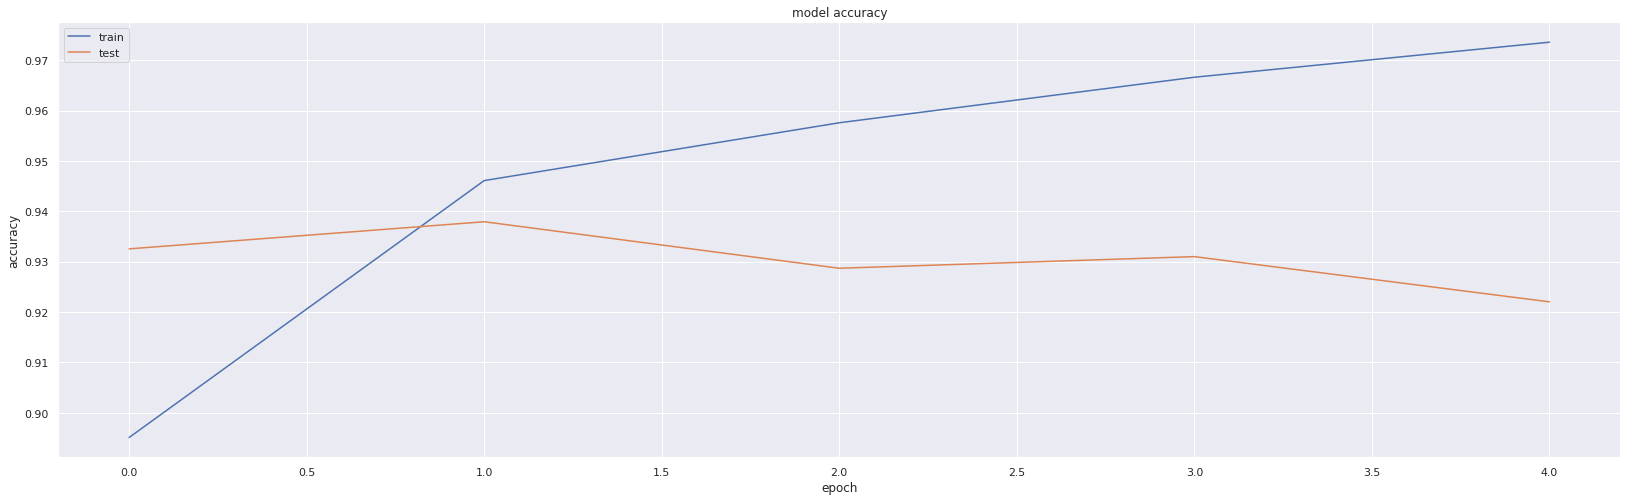

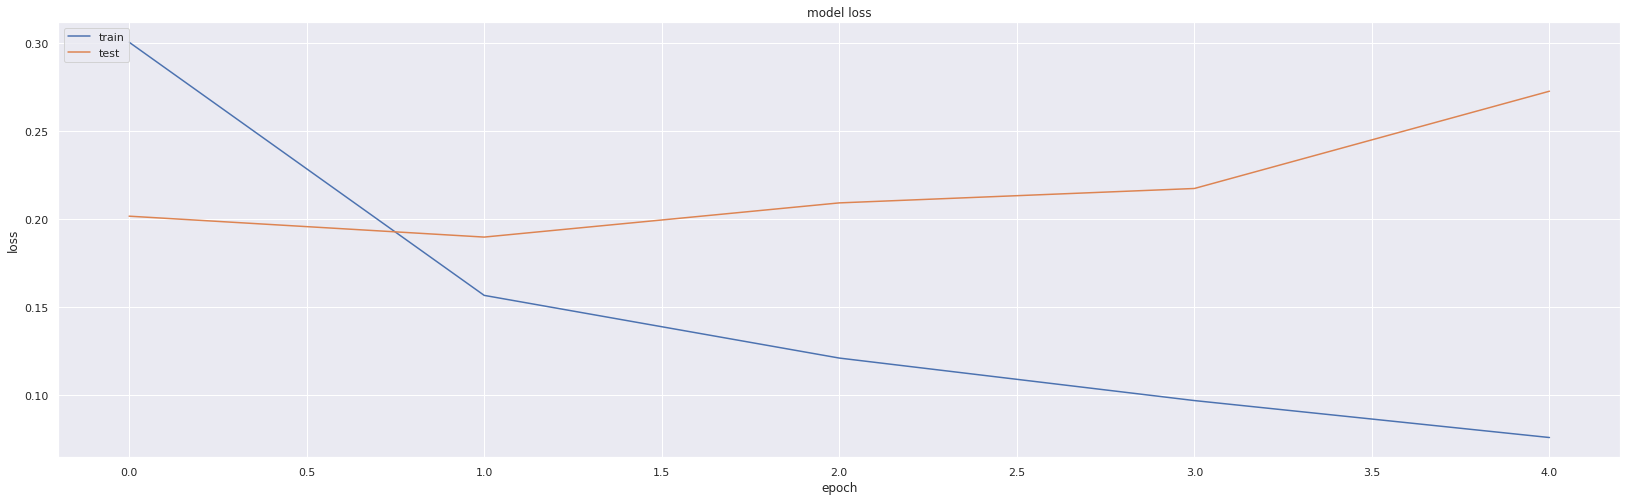

In [ ]:
# the accuracy and loss plots for the 5 epochs are plotted below.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# the predictions are stored in y_pred variable.
y_pred = model.predict(x_test)
y_pred.shape

(7798, 5)

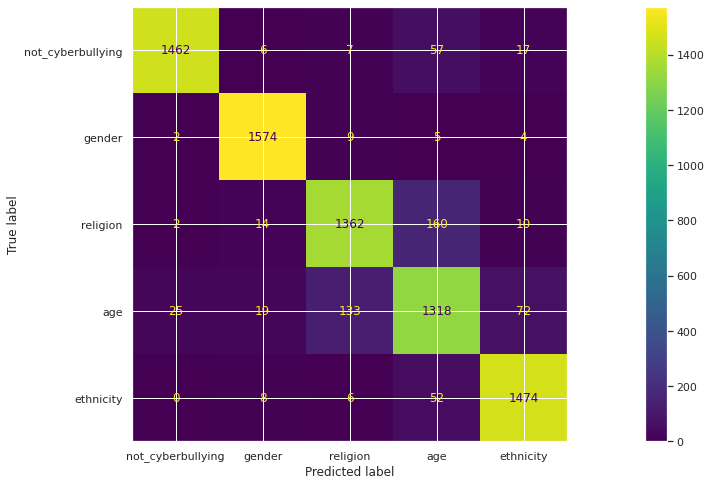

In [ ]:
# the confusion matrix is plotted to see the performance of the model. 
c = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=c, display_labels=test_df["cyberbullying_type"].unique())
disp.plot()